In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from data_cleaner import *
from room_energy import energyLossAllRooms, energy_to_building

In [2]:
df_fcu_sth_raw = pd.read_csv('data/Gnd floor FCU Sth 16032020.csv')
df_fcu_nth_raw = pd.read_csv('data/Gnd floor FCU North 16032020.csv')
df_ahu_raw = pd.read_csv('data/Gnd AHU multi list 16032020.csv')
df_chiller_boiler_raw = pd.read_csv('data/more_Data/chillers boilers thermal Feb 23032020.csv')
room_info_raw = pd.read_csv('data/Room Details.csv')
df_ltb_space_raw = pd.read_csv('data/LTB Space Data.csv')

In [3]:
df_ltb_temps = create_temp_df(df_fcu_sth_raw, df_fcu_nth_raw, df_ahu_raw)
df_chiller_boiler_power = create_chiller_boiler_power_df(df_chiller_boiler_raw)
df_room_info = create_room_info_df(room_info_raw)

# Ignore rooms with no external walls
df_ltb_temps = df_ltb_temps.drop(['AHU-B1-02 ZnTmp_1', 'AHU-B1-02 ZnTmp_2','FCU-16 ZnTmp', 'FCU-15 ZnTmp'], axis=1)
df_room_info = df_room_info[df_room_info['AHU / FCU'] != 'AHU-B1-02']
df_room_info = df_room_info[df_room_info['AHU / FCU'] != 'FCU-16']
df_room_info = df_room_info[df_room_info['AHU / FCU'] != 'FCU-15']


In [4]:
df_energy_room_change = energyLossAllRooms(df_ltb_temps, df_room_info, time_frame=["06:00", "18:00"])
df_energy_external = energy_to_building(df_ltb_temps, df_room_info, time_frame=["06:00", "18:00"])

# Plotting results

#### Single Day Temperature results

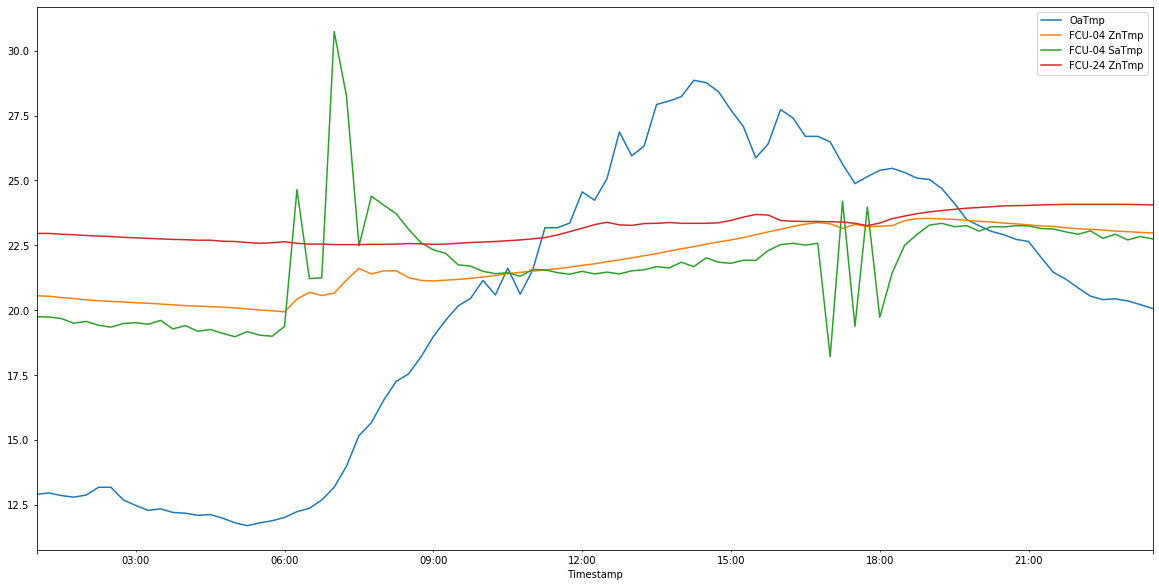

In [5]:
START_DATE = '2020-02-06 01:10:0'  
END_DATE = '2020-02-06 23:59:59'
df_ltb_temps_day = create_temp_df(df_fcu_sth_raw, df_fcu_nth_raw, df_ahu_raw, START_DATE, END_DATE)

time_frame = ["00:00", "23:30"]
zn_tmp = 'FCU-04 ZnTmp'
sa_tmp = 'FCU-04 SaTmp'
df_ltb_temps_day = df_ltb_temps_day.between_time(time_frame[0], time_frame[1])
delta_temp = df_ltb_temps_day['OaTmp'] - df_ltb_temps_day[zn_tmp]
 
# Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()

df_ltb_temps_day['OaTmp'].plot(kind='line', ax=ax, legend=True)
df_ltb_temps_day[zn_tmp].plot(kind='line', ax=ax, legend=True)
df_ltb_temps_day[sa_tmp].plot(kind='line', ax=ax, legend=True)
df_ltb_temps_day['FCU-24 ZnTmp'].plot(kind='line', ax=ax, legend=True)


#delta_temp.plot(kind='line', ax=ax, legend=True)

plt.show()

#### Full Time Period

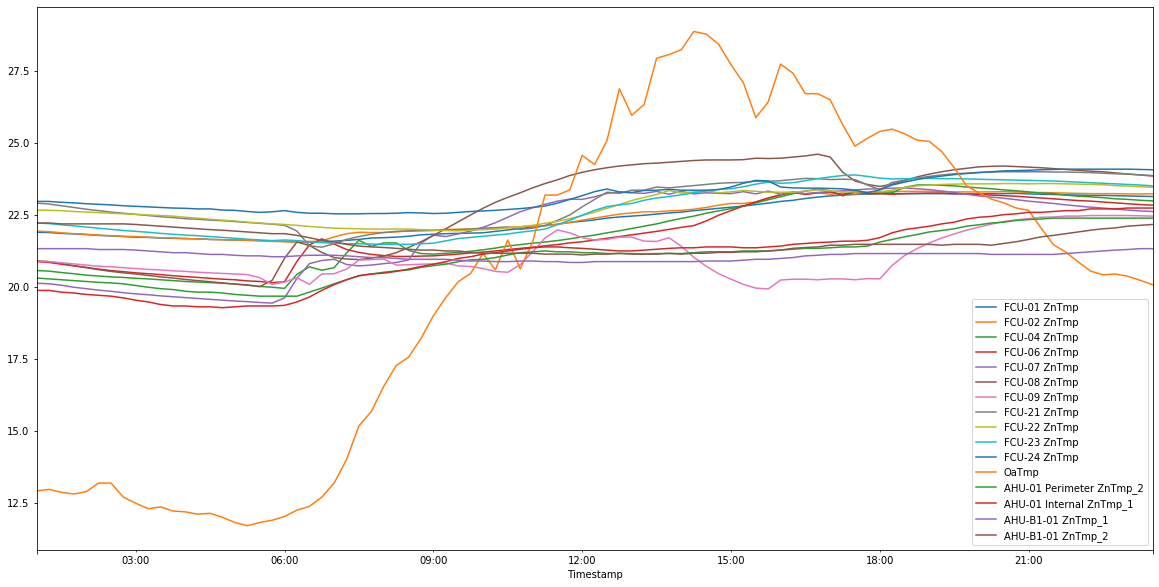

In [6]:
time_frame = ["06:00", "18:00"]
df_ltb_temps_open = df_ltb_temps.between_time(time_frame[0], time_frame[1])
 
# Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()

for col in df_ltb_temps_open.columns:
    if 'Sa' not in col and 'OaRH' not in col:
        df_ltb_temps_day[col].plot(kind='line', ax=ax, legend=True)

plt.show()

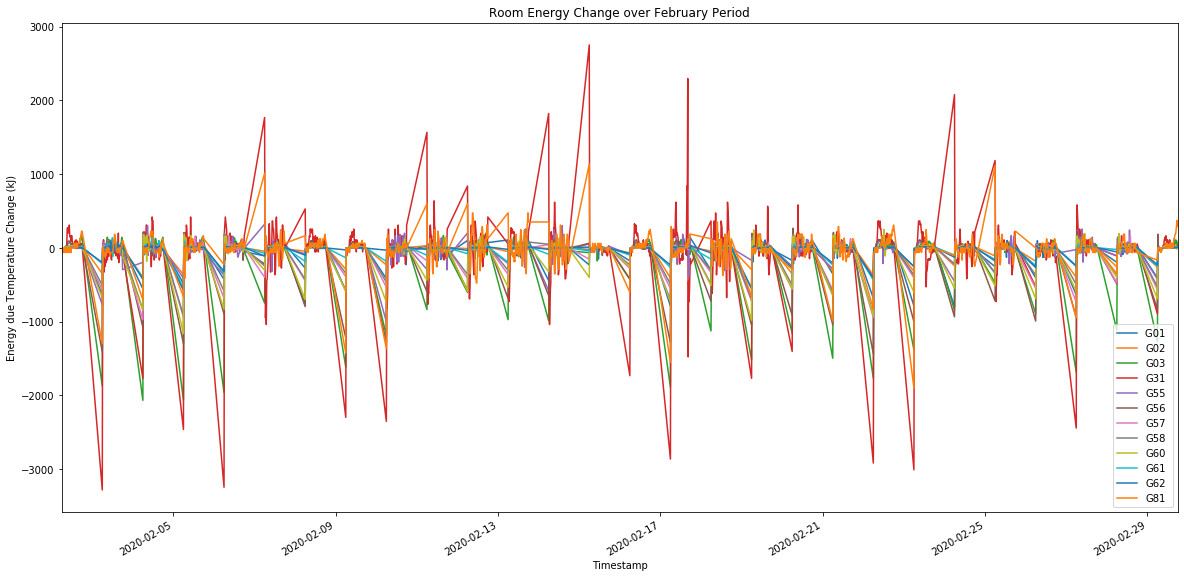

In [7]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("Room Energy Change over February Period")
ax.set_ylabel("Energy due Temperature Change (kJ)")
for col in df_energy_room_change.columns:
    df_energy_room_change[col].plot(kind='line', ax=ax, legend=True)

plt.legend(loc="lower right")
plt.show()

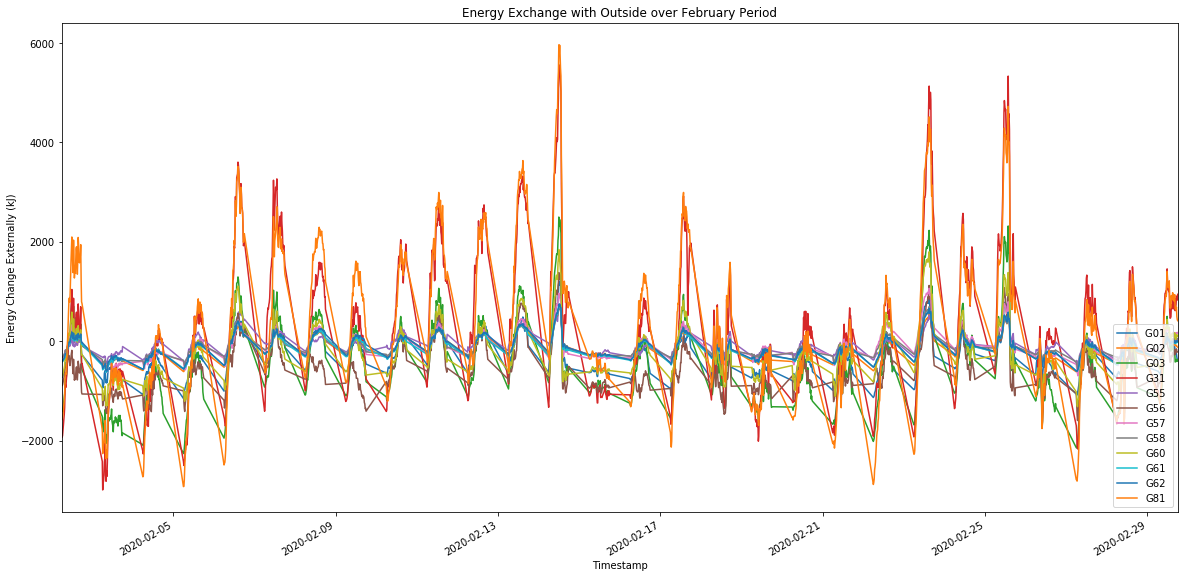

In [8]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("Energy Exchange with Outside over February Period")
ax.set_ylabel("Energy Change Externally (kJ)")
for col in df_energy_external.columns:
    df_energy_external[col].plot(kind='line', ax=ax, legend=True)
    
plt.legend(loc="lower right")
plt.show()

Assuming change in room energy = incoming energy from outside - reduction of energy from AC

-> reduction of energy from AC = incoming - change in room 

In [9]:
df_effectice_ac_energy = df_energy_external - df_energy_room_change
df_effectice_ac_energy.iloc[1:3]



,G01,G02,G03,G31,G55,G56,G57,G58,G60,G61,G62,G81
Timestamp,,,,,,,,,,,,
2020-02-02 06:15:00,-720.777571,-405.713723,-1400.236542,-1881.470067,-315.428957,-888.298640,-387.560789,-328.558477,-707.780997,-413.167768,-397.806552,-1580.653157
2020-02-02 06:30:00,-707.049935,-398.428898,-1369.461053,-1843.580292,-315.498327,-868.839499,-385.881554,-322.558053,-689.359535,-405.434263,-390.927541,-1485.051801


In [10]:
df_energy_external.iloc[1:3]

,G01,G02,G03,G31,G55,G56,G57,G58,G60,G61,G62,G81
Timestamp,,,,,,,,,,,,
2020-02-02 06:15:00,-727.303253,-408.668288,-1416.319790,-1936.167503,-322.063088,-894.739973,-393.295865,-328.558477,-707.780997,-416.282328,-397.806552,-1580.653157
2020-02-02 06:30:00,-716.838457,-404.338028,-1393.585924,-1898.277728,-318.815392,-878.501497,-388.749091,-325.310783,-695.656269,-411.663384,-394.342344,-1547.093642


In [11]:
df_energy_room_change.iloc[1:3]

,G01,G02,G03,G31,G55,G56,G57,G58,G60,G61,G62,G81
Timestamp,,,,,,,,,,,,
2020-02-02 06:15:00,-6.525682,-2.954565,-16.083248,-54.697436,-6.634131,-6.441332,-5.735075,0.000000,0.000000,-3.114560,0.000000,0.00000
2020-02-02 06:30:00,-9.788522,-5.909129,-24.124872,-54.697436,-3.317065,-9.661999,-2.867538,-2.752729,-6.296734,-6.229121,-3.414803,-62.04184


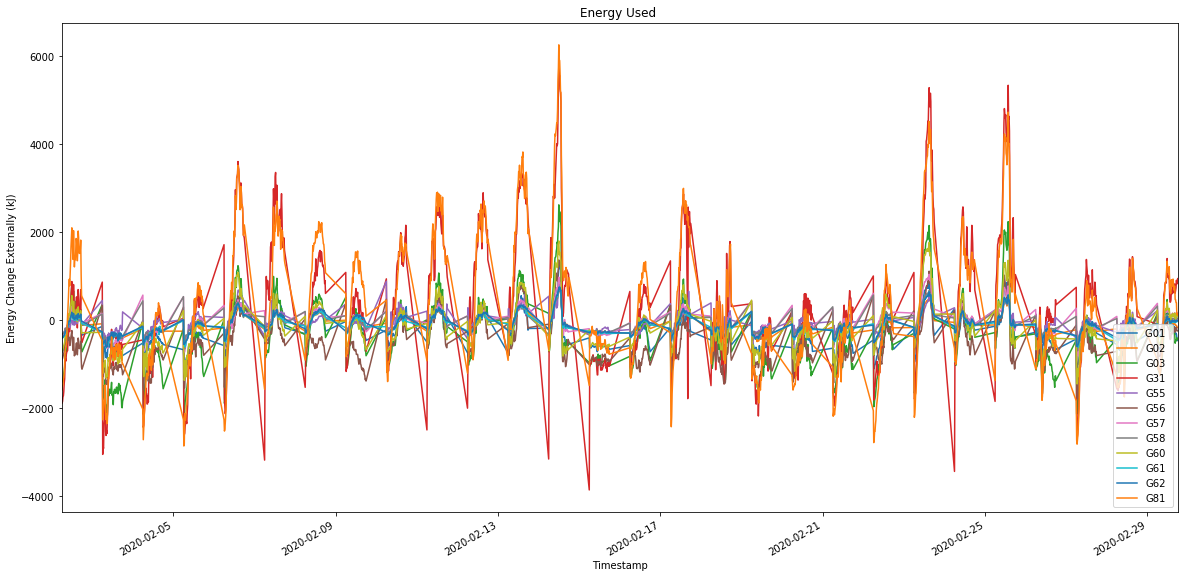

In [12]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("Energy Used ")
ax.set_ylabel("Energy Change Externally (kJ)")
for col in df_effectice_ac_energy.columns:
    df_effectice_ac_energy[col].plot(kind='line', ax=ax, legend=True)
    
plt.legend(loc="lower right")
plt.show()

In [13]:
ac_energy_work = df_effectice_ac_energy.abs().sum().sum()

In [14]:
chiller_energy, boiler_energy = get_power_used(df_chiller_boiler_power)
print(chiller_energy)

total_ac_energy_used = chiller_energy + boiler_energy

ac_floor_area = df_room_info['Total Area'].sum()
ltb_foor_area = df_ltb_space_raw['Room Area'].sum()
gnd_floor_area = df_ltb_space_raw[df_ltb_space_raw['Floor'] == '01']['Room Area'].sum()

ac_area_multiplier = ltb_foor_area / ac_floor_area
building_ac_energy_work = ac_area_multiplier * ac_energy_work


550877652.0


In [15]:
BTU = building_ac_energy_work/ 1.055  # kJ to BTU
total_ac_wh = total_ac_energy_used/ 3.6  # kJ to Wh

In [16]:
SEER = BTU/total_ac_wh

In [17]:
SEER

0.5918276323422964